In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imgplt
import os
import seaborn as sns
import networkx as nx
from networkx.algorithms import community
import csv

In [2]:
file_path_1 = r'fullevents.csv'
file_path_2 = r'matches_2.csv'
file_path_3 = r'passingevents_1.csv'
full_events = pd.read_csv(file_path_1)
matches = pd.read_csv(file_path_2)
passing_events = pd.read_csv(file_path_3)
passing_events.head()

,MatchID,TeamID,OriginPlayerID,OriginPlayerName,DestinationPlayerID,DestinationPlayerName,MatchPeriod,EventTime,EventSubType,EventOrigin_x,EventOrigin_y,EventDestination_x,EventDestination_y,Mid_x,Mid_y,PositionWeight,PositionWeight_fil,PositionWeight_n
0,1,Everton,Everton_D1,Keane,Everton_F1,Lewin,1H,46.323501,Head pass,34,97,59,95,46.5,96.0,1.85171,1.85171,0.200930
1,1,Everton,Everton_M1,Gueye,Everton_F2,Rooney,1H,51.022546,Simple pass,53,89,69,91,61.0,90.0,2.51219,2.51219,0.356747
2,1,Opponent1,Opponent1_D2,Opponent1_D2,Opponent1_G1,Opponent1_G1,1H,89.008721,Simple pass,19,16,5,50,12.0,33.0,1.38335,1.38335,0.090438
3,1,Opponent1,Opponent1_G1,Opponent1_G1,Opponent1_F1,Opponent1_F1,1H,92.216160,Launch,5,50,67,44,36.0,47.0,2.98005,2.98005,0.467122
4,1,Everton,Everton_M2,Klaassen,Everton_M3,Schneiderlin,1H,98.265191,Simple pass,42,55,36,54,39.0,54.5,1.70071,1.70071,0.165307


In [3]:
Everton_passing_df = passing_events.loc[passing_events.TeamID == 'Everton'].reset_index(drop = True)
Everton_player = [player for player in Everton_passing_df.OriginPlayerName.unique().tolist()]
print(Everton_player)

#存每场比赛传球数据
max_MatchID = passing_events.MatchID.max()
passing_dict = {}
for match_index in range(1, max_MatchID+1):
    passing_dict['Match' + str(match_index)] = passing_events.loc\
    [passing_events.MatchID == match_index].reset_index(drop = True)

#存每场比赛埃弗顿队传球数据,由passing_events字典筛选
Everton_passing_dict = {}
for index in range(1, max_MatchID+1):
    Everton_passing_dict['Match' + str(index)] = passing_dict['Match' + str(index)].loc\
    [passing_dict['Match' + str(index)].TeamID == 'Everton'].reset_index(drop = True)
Everton_passing_dict['Match1'].head()

['Keane', 'Gueye', 'Klaassen', 'Pickford', 'Williams', 'Jagielka', 'Baines', 'Schneiderlin', 'Rooney', 'Ramirez', 'Lewin', 'Martina', 'Davies', 'Mirallas', 'Holgate', 'Sigursson', 'Besic', 'Lennon', 'Vlasic', 'Niasse', 'Kenny', 'Lookman', 'Baningime', 'Bolasie', 'McCarthy', 'Tosun', 'Walcott', 'Coleman', 'Mangala', 'Mori']


,MatchID,TeamID,OriginPlayerID,OriginPlayerName,DestinationPlayerID,DestinationPlayerName,MatchPeriod,EventTime,EventSubType,EventOrigin_x,EventOrigin_y,EventDestination_x,EventDestination_y,Mid_x,Mid_y,PositionWeight,PositionWeight_fil,PositionWeight_n
0,1,Everton,Everton_D1,Keane,Everton_F1,Lewin,1H,46.323501,Head pass,34,97,59,95,46.5,96.0,1.85171,1.85171,0.200930
1,1,Everton,Everton_M1,Gueye,Everton_F2,Rooney,1H,51.022546,Simple pass,53,89,69,91,61.0,90.0,2.51219,2.51219,0.356747
2,1,Everton,Everton_M2,Klaassen,Everton_M3,Schneiderlin,1H,98.265191,Simple pass,42,55,36,54,39.0,54.5,1.70071,1.70071,0.165307
3,1,Everton,Everton_D1,Keane,Everton_F1,Lewin,1H,130.656530,Head pass,34,91,52,97,43.0,94.0,1.46889,1.46889,0.110618
4,1,Everton,Everton_D1,Keane,Everton_G1,Pickford,1H,161.221470,Simple pass,14,65,11,50,12.5,57.5,1.37099,1.37099,0.087522


In [4]:
#坐标转换函数，传入参数：数据集中的一行
#埃弗顿无需转置，对手x轴，y轴需全部转置
def coord_convert(sg_record):
    if 'Everton' in str(sg_record.TeamID):
        ocoord = (sg_record.EventOrigin_x, sg_record.EventOrigin_y)
        dcoord = (sg_record.EventDestination_x, sg_record.EventDestination_y)
    else:
        ocoord = (100-sg_record.EventOrigin_x, 100-sg_record.EventOrigin_y)
        dcoord = (100-sg_record.EventDestination_x,100-sg_record.EventDestination_y)
    #x为长轴，y为短轴，坐标全部以进攻方向为正，交换球权转换坐标，坐标原点为进攻方向左下角
    return ocoord, dcoord

In [5]:
#点集控制函数，将算术均值作为节点坐标
def node_control(item, Oxy, Dxy):
    if(len(Oxy) == 0):
        Oxmean = 0
        Oymean = 0
    else:
        Oxmean = Oxy.EventOrigin_x.mean()
        Oymean = Oxy.EventOrigin_y.mean()
    if(len(Dxy) == 0):
        Dxmean = 0
        Dymean = 0
    else:
        Dxmean = Dxy.EventDestination_x.mean()
        Dymean = Dxy.EventDestination_y.mean()
    
    #round返回四舍五入值，y值需转置
    x = round(Oxmean + Dxmean)/2
    y = 100 - round(Oymean + Dymean)/2
    
    return x, y

In [6]:
def edge_control(i, j):
    #edgeweight计算球员i传向j的所有传球权重之和
    edgeweight = interact_df.loc[(interact_df.OriginPlayerName == i) & (interact_df.DestinationPlayerName == j)]\
    [['PositionWeight_fil']].sum()
    #如果球员之间没有传球，跳出函数
    if float(edgeweight) == 0:
        return
    #否则添加边，将数据转化为浮点数类型并保留5位小数
    else:
        edgelist.append((i, j, round(float(edgeweight),5)))
    return edgelist

In [16]:
Match_list = []#比赛场次列表
avr_cl = []#网络平均聚类系数
avr_sp = []#网络平均最短路径长度
tr = []#图的传递性（可能三角形分数）
no_co = []#图的节点连通性近似值
cl_ce = []#平均接近中心性
ei_ce = []#平均特征向量中心性
be_ce = []#平均中介中心性
sw = []#网络小世界性

In [128]:
Match_num = 38
interact_df = Everton_passing_dict['Match' + str(Match_num)]\
[['OriginPlayerName','DestinationPlayerName','PositionWeight_fil']].reset_index(drop=True)
coordinates = Everton_passing_dict['Match' + str(Match_num)]\
[['OriginPlayerName','DestinationPlayerName','EventOrigin_x','EventOrigin_y','EventDestination_x','EventDestination_y']].reset_index(drop=True)

#创建一个空的有向图
G = nx.DiGraph()

pos = {}
nodelist = []
nodesize = []
edgelist = []
edgewidth = []

for item in set(coordinates.OriginPlayerName.unique().tolist() + coordinates.DestinationPlayerName.unique().tolist()):
    #向节点列表添加元素
    nodelist.append(item)
    Oxy = (coordinates.loc[coordinates.OriginPlayerName == item][['EventOrigin_x','EventOrigin_y']])
    Dxy = (coordinates.loc[coordinates.DestinationPlayerName == item][['EventDestination_x','EventDestination_y']])
    #调用node_control确定节点位置
    x, y = node_control(item, Oxy, Dxy)
    pos[item] = (x,y)

#向图中添加节点
G.add_nodes_from(nodelist)

#双循环遍历节点集合，调用edge_control添加边
for i in set(nodelist):
    for j in set(nodelist):
        if(i == j):
            continue
        else:
            edge_control(i, j)

#向图中添加边
G.add_weighted_edges_from(edgelist)
#print(G.edges,data())

print('节点数：{}'.format(len(nodelist)))
print('边数：{}'.format(len(edgelist)))

#更新节点信息，将节点Pagerank值作为权重
pr = nx.pagerank(G)
for n, prvalue in pr.items():
    G.nodes[n]['weight'] = prvalue
#print(G.nodes.data())

节点数：14
边数：100


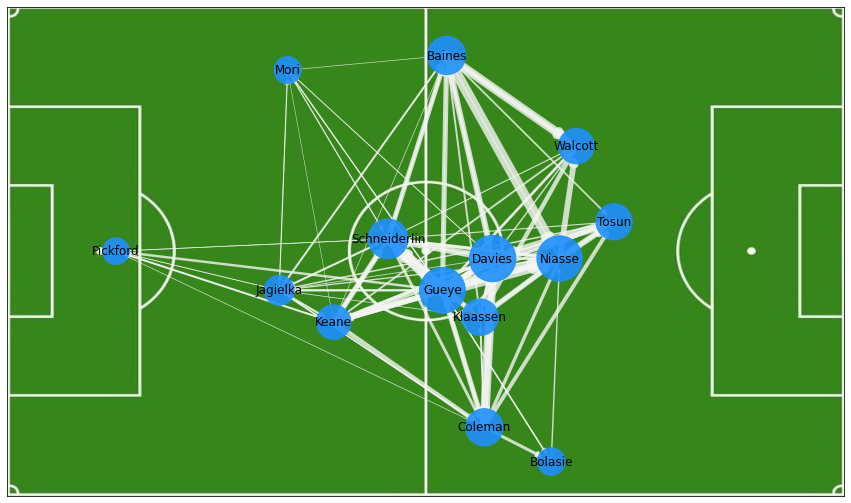

In [129]:
#调整节点大小，边的宽度
nodesize.clear()
edgewidth.clear()
for u, v in G.nodes(data = True):
    n_sg_weight = 500+12000*v['weight']
    nodesize.append(n_sg_weight)

for u, v, d in G.edges(data = True):
    e_sg_weight = 0.5*d['weight']
    edgewidth.append(e_sg_weight)

#绘制图像，插入足球场
back_pic = imgplt.imread('field.png', 0)
plt.figure(figsize = (15, 9))

#pos = nx.spring_layout(G, iterations = 20)
#alpha透明度
nx.draw_networkx_nodes(G, pos, node_size = nodesize, alpha = 0.9, node_color = 'dodgerblue')
nx.draw_networkx_edges(G, pos, width = edgewidth, alpha = 0.8, edge_color = 'whitesmoke')
nx.draw_networkx_labels(G, pos, font_color = 'k')
plt.imshow(back_pic, aspect = 'auto', extent = (0,100,0,100))
#保存图片
fig_name = 'charts/Match' + str(Match_num) + '.png'
plt.savefig(fig_name)

In [130]:
#以边权重倒数为边距离
for u,v,d in G.edges.data():
    d['weight'] = 1/d['weight']

#计算所有指标
Match_list.append(Match_num)
avr_cl.append(nx.average_clustering(G))#网络平均聚类系数
avr_sp.append(nx.average_shortest_path_length(G))#网络平均最短路径长度
tr.append(nx.transitivity(G))#图的传递性（可能三角形分数）
no_co.append(nx.node_connectivity(G))#图的节点连通性近似值
cl_ce.append(np.mean(list(nx.closeness_centrality(G).values())))#平均接近中心性
ei_ce.append(np.mean(list(nx.eigenvector_centrality(G).values())))#平均特征向量中心性
be_ce.append(np.mean(list(nx.betweenness_centrality(G).values())))#平均中介中心性
#nx.clustering(G)#局部聚类系数
print('Directed calculate finished !')

'''#有向图转化无向图，边权重为有向图相反方向边的权重之和
G1 = G.to_undirected()
for u, v, d in G1.edges(data = True):
    if(G.has_edge(u, v) == G.has_edge(v, u) == True):
        G1[u][v]['weight'] = G[u][v]['weight'] + G[v][u]['weight']
sw.append(nx.omega(G1))#网络小世界性
print('Undirected calculate finished !')'''

Directed calculate finished !


"#有向图转化无向图，边权重为有向图相反方向边的权重之和\nG1 = G.to_undirected()\nfor u, v, d in G1.edges(data = True):\n    if(G.has_edge(u, v) == G.has_edge(v, u) == True):\n        G1[u][v]['weight'] = G[u][v]['weight'] + G[v][u]['weight']\nsw.append(nx.omega(G1))#网络小世界性\nprint('Undirected calculate finished !')"

In [131]:
print(len(Match_list),Match_list)

38 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]


In [134]:
#取待写入行
#write_row = matches.loc[matches.MatchID == Match_num]\
#[['average_clustering','average_shortest_path','transitivity','node_connectivity','closeness_centrality','eigenvector_centrality','betweenness_centrality','small_world']]
#newline = ''防止跳行
f = open('matches_1.csv', 'w', newline = '', encoding = 'utf-8')
csv_writer = csv.writer(f)
csv_writer.writerow(['Match_num', 'average_clustering','average_shortest_path','transitivity','node_connectivity','closeness_centrality','eigenvector_centrality','betweenness_centrality'])
for i in range(0, len(Match_list)):
    csv_writer.writerow([Match_list[i], avr_cl[i], avr_sp[i], tr[i], no_co[i], cl_ce[i], ei_ce[i], be_ce[i]])
f.close()

In [ ]:
#存储邻接矩阵
import xlwt  # 负责写excel
import xlrd
#提取邻接矩阵
G_matrix = nx.adjacency_matrix(G).todense()

filename = xlwt.Workbook() #创建工作簿
sheet1 = filename.add_sheet(u'sheet1', cell_overwrite_ok=True) #创建sheet
[h,l] = G_matrix.shape #h为行数，l为列数
for i in range (h):
    for j in range (l):
        sheet1.write(i, j, G_matrix[i,j])
filename.save('matrix.xls')
print(G.edges.data())